# Parameter estimation of Gaussian mixture models using EM

In [1]:
%matplotlib inline

In [6]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, style='white')

Let's think about this carefully. We have the EM algorithm written down for us:
### Algorithm
> Given a Gaussian mixture model, the goal is to maximize the likelihood function with respect to the parameters (comprising the means and covariances of the components and the mixing coefficients).
1. Initialize the means $\boldsymbol{\mu}_k$, covariances $\boldsymbol{\Sigma}_k$ and mixing coefficients $\pi_k$, and evaluate the initial value of the log likelihood.
2. **E step**. Evaluate the responsibilities using the current parameter values. $$
        \gamma(z_{nk}) = \frac{\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}$$
3. **M step**. Re-estimate the parameters using the current responsibilities
    \begin{eqnarray}
    \boldsymbol{\mu}_k^{\mathrm{new}} & = & \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})\mathbf{x}_n \\
    \boldsymbol{\Sigma}_k^{\mathrm{new}} & = & \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(\mathbf{x}_n-\boldsymbol{\mu}_k^{\mathrm{new}})(\mathbf{x}_n-\boldsymbol{\mu}_k^{\mathrm{new}})^T\\
    \pi_k^{\mathrm{new}} & = & \frac{N_k}{N}
    \end{eqnarray}
where $$N_k = \sum_{n=1}^N\gamma(z_{nk}).$$
4. Evaluate the log likelihood
$$
\log p(\mathbf{x}|\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{n=1}^N\log\left\{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right\}
$$
and check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied then return to step 2.

So what do we need? Let's take an example of a 2-D Gaussian mixture model. Use the example we had before, we have $\boldsymbol{\mu}$ being a 2-D vector, and $\boldsymbol{\Sigma}$ is a 2x2 matrix. If our mixture model consists of three Gaussians, then $k = 3$.

We need the following functions:
- `_estimate_log_likelihood`, which takes as input $\mathbf{X}$, weights, means and covariance.
- `_e_step`: this takes as input the n-samples ($2\times n$ matrix), the weights ($1\times 3$ vector), means ($2\times 3$ matrix) and covariances ($2\times2\times3$ matrix). We need to compute the responsibilities, which is an $n\times k$ matrix. What we need to do is to be able to compute the probability of a multivariate normal distribution with given parameters for the n-samples. This requires me to look up the scipy.stats package.
- `_m_step`: this takes in the responsibility matrix ($n\times k$), the samples $\mathbf{X}$ and it will output the new weights, means and covariances

And that should be it! We want to work in log space and divide things into small functions.

In [16]:
def gen_pos_def_matrix(size):
    """Generate a random positive-definite matrix for MVN sampling. 
    This can be simply achieved by multiplying a matrix with its transpose.
    See wikipedia article.
    http://en.wikipedia.org/wiki/Positive-definite_matrix#Negative-definite.2C_semidefinite_and_indefinite_matrices
    """
    A = np.random.randint(-10, 10, size=(size, size))*0.1 # Let the values not be too large
    return A.dot(A.T)

In [85]:
def create_sample(n):
    """Here we sample from three 2x2 multivariate Gaussians, 
    multiply them by the given weights and 
    combine them to return a 3n x 2 matrix for inference.
    """
    mu1, sigma1 = [0.2, 0.2], [[0.53, 0.51], [0.51, 0.89]]
    mu2, sigma2 = [0.5, 0.5], [[0.34, 0.63], [0.63, 1.17]]
    mu3, sigma3 = [0.8, 0.75], [[ 0.13, -0.29], [-0.29,  1.09]]
    
    weights = [0.2, 0.3, 0.5] # weights must add up to 1
    
    # Sampling
    X1 = np.random.multivariate_normal(mu1, sigma1, 2*n)
    X2 = np.random.multivariate_normal(mu2, sigma2, 3*n)
    X3 = np.random.multivariate_normal(mu3, sigma3, 5*n)
    
    act_weights = np.array(weights)
    act_means =  np.array([mu1, mu2, mu3])
    act_covs = np.array([sigma1, sigma2, sigma3])
        
    return np.concatenate((X1, X2, X3), axis=0), act_weights, act_means, act_covs

We randomly sample 300 points (100 from each distribution) and plot the samples.

In [86]:
X, act_weights, act_means, act_covs = create_sample(100)

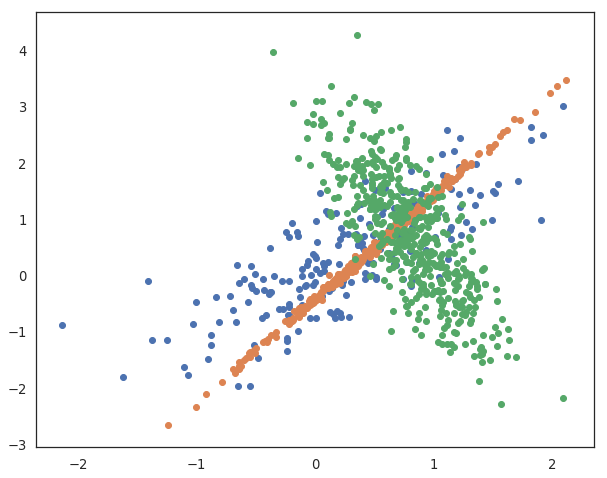

In [88]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:200,0], X[:200, 1])
plt.scatter(X[200:-500,0], X[200:-500,1])
plt.scatter(X[-500:, 0], X[-500:,1]);

In [89]:
def _estimate_gaussian_covariances(resp, X, nk, means):
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[::n_features + 1] += 1.e-6
    return covariances

In [90]:
def _estimate_gaussian_parameters(X, resp):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    
    covariances = _estimate_gaussian_covariances(resp, X, nk, means)
    
    return nk, means, covariances

In [91]:
def _estimate_log_gaussian_prob(X, means, cov):
    """This uses the scipy.stat.smultivariate_normal class, might cause problems 
    if the covariance matrix is not positive semi-definite. """
    rv = multivariate_normal(means, cov)
    return np.log(rv.pdf(X))

In [92]:
def _estimate_log_prob(X, means, covariances):
    """Estimate log probability.
    Parameters
    ----------
    X : array-like, shape (n_samples, 2)
    Returns
    -------
    log_prob : array, shape (n_samples, n_components)
    """
    n_samples, _ = X.shape
    n_components, _ = means.shape
    
    log_prob = np.empty([n_samples, n_components])
    
    for k in range(n_components):
        log_prob[:, k] = _estimate_log_gaussian_prob(X, means[k], covariances[k])    
    return log_prob

In [93]:
def _estimate_log_weights(weights_):
    return np.log(weights_)

In [94]:
def _estimate_log_prob_resp(X, weights, means, covariances):
    """Estimate log probabilities and responsibilities for each sample.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, 2)
    
    weights: array-like, shape (n_components,)
    
    means: array-like, shape (n_components, 2)
    
    covariances: array-like, shape (n_components, 2, 2)
    
    Returns
    -------
    log_prob_norm : array, shape (n_samples,)
    
    log_responsibilities : array, shape (n_samples, n_components)
        logarithm of the responsibilities
    """
    log_prob = _estimate_log_prob(X, means, covariances)
    
    weighted_log_prob = log_prob + _estimate_log_weights(weights)   
    
    log_prob_norm = np.log(np.sum(np.exp(weighted_log_prob), axis=1))
        
    log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
    
    return log_prob_norm, log_resp

In [95]:
def _estimate_log_likelihood(X, weights, means, covariances):
    """Estimate log likelihood """
    n_samples, _ = X.shape
    n_components, _ = means.shape
    
    log_prob = _estimate_log_prob(X, means, covariances)
    return np.sum(np.log(np.exp(log_prob).dot(weights)))

In [96]:
def _e_step(X, weights, means, covariances):
    """E step.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    Returns
    -------
    log_prob_norm : float
        Mean of the logarithms of the probabilities of each sample in X
    log_responsibility : array, shape (n_samples, n_components)
        Logarithm of the posterior probabilities (or responsibilities) of
        the point of each sample in X.
    """
    log_prob_norm, log_resp = _estimate_log_prob_resp(X, weights, means, covariances)
    
    return np.mean(log_prob_norm), log_resp

In [97]:
def _m_step(X, log_resp):
    """M step.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    log_resp : array-like, shape (n_samples, n_components)
        Logarithm of the posterior probabilities (or responsibilities) of
        the point of each sample in X.
    """
    n_samples, _ = X.shape
    weights_, means_, covariances_ = (_estimate_gaussian_parameters(X, np.exp(log_resp)))
    
    weights_ /= n_samples
    return weights_, means_, covariances_
   
def _compute_lower_bound(_, log_prob_norm):
    return log_prob_norm

Now try this out:

In [101]:
weights = np.array([0.3, 0.3, 0.4])
means = np.array([[0.2, 0.2], [0.3, 0.5], [0.2, 0.8]])
variances = np.array([np.eye(2)*0.5, np.eye(2)*0.5, np.eye(2)*0.5])

In [102]:
print('actual:', act_weights, act_means, act_covs)

actual: [0.2 0.3 0.5] [[0.2  0.2 ]
 [0.5  0.5 ]
 [0.8  0.75]] [[[ 0.53  0.51]
  [ 0.51  0.89]]

 [[ 0.34  0.63]
  [ 0.63  1.17]]

 [[ 0.13 -0.29]
  [-0.29  1.09]]]


In [103]:
max_iter = 100
lower_bound = -np.infty
tol = 1.e-4

log_likelihood = []

for n_iter in range(1, max_iter + 1):
    prev_lower_bound = lower_bound
    log_prob_norm, log_resp = _e_step(X, weights, means, variances)
    weights, means, variances = _m_step(X, log_resp)
        
    lower_bound = _compute_lower_bound(log_resp, log_prob_norm)
    change = lower_bound - prev_lower_bound

    if abs(change) < tol:
        print('Converged')
        print('Weights:', weights, 'Means:', means, 'covariances:', variances)
        break

Converged
Weights: [0.21002659 0.29206699 0.49790642] Means: [[0.27103788 0.33794394]
 [0.4705445  0.44514773]
 [0.79662441 0.72473925]] covariances: [[[ 0.50830226  0.53661749]
  [ 0.53661749  0.93529743]]

 [[ 0.31714016  0.58512662]
  [ 0.58512662  1.08223355]]

 [[ 0.13431471 -0.3015155 ]
  [-0.3015155   1.15939371]]]


/home/yl238/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
